# Fraud Detection Data Challenge

## Content
Of course, it's not easy finding good datasets in applying fraud detection methodologies, but this dataset comes pretty close. It's from a [2013 Kaggle Competition](https://www.kaggle.com/mlg-ulb/creditcardfraud).

From the competition description:
___
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the competition organizers cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, \
                            roc_auc_score, accuracy_score, classification_report, \
                            average_precision_score, precision_recall_curve
    
# Modeling Functions
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
   
# For implementing deep learning using TensorFlow
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Ignore some unneeded warnings
import warnings  
warnings.filterwarnings('ignore')

df = pd.read_csv('../input/creditcard.csv')
df.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


That PCA was performed already on the entire dataset likely means that there will be some leakage across the training and testing sets. This could lead to a better performance on the testing set because, theoretically, some of the variation within that testing set 'leaked' into the training set as part of the process of fitting PCA to the full dataset. While I understand the need for privacy, if I were doing this analysis on a set of more real world data, I would only fit PCA to the training subset and then transform both the training and testing subsets based on the training PCA only to prevent such leakage. 

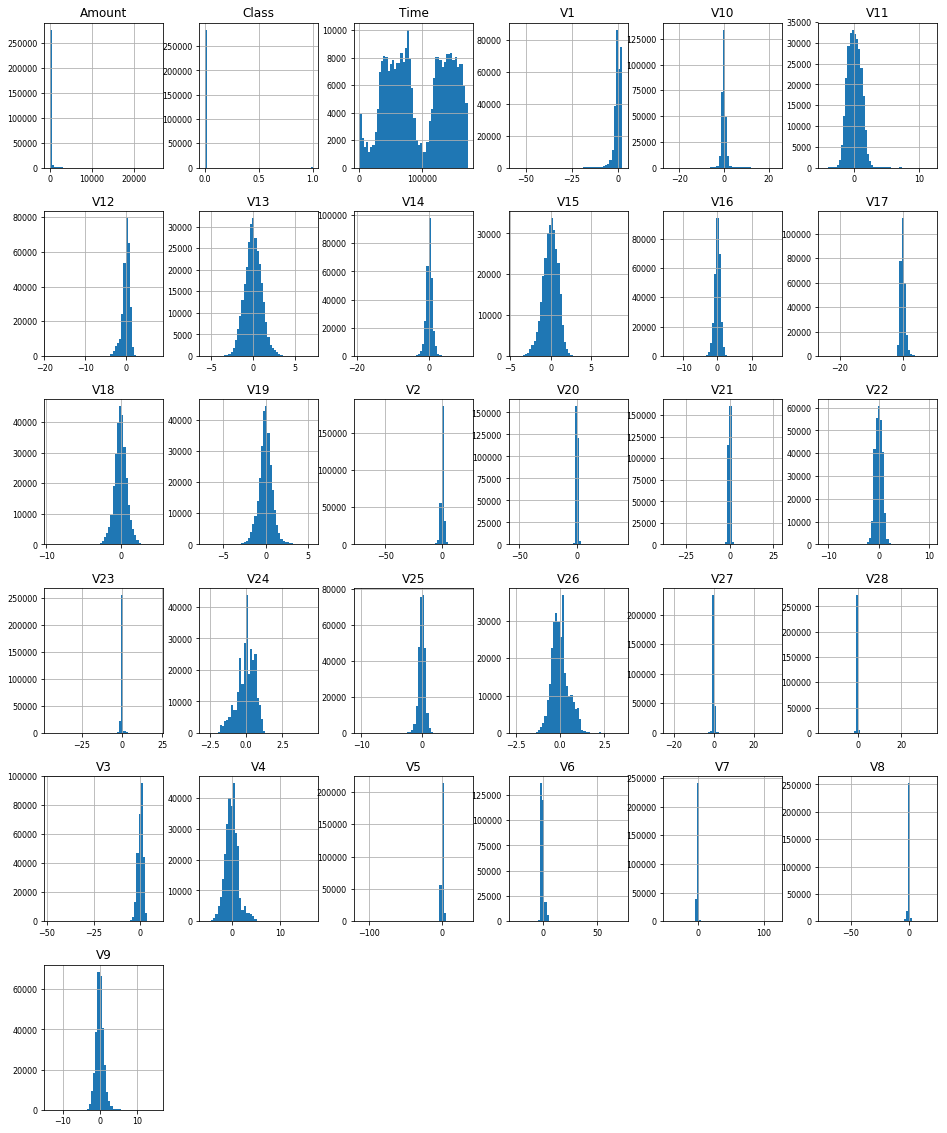

In [2]:
# Explore distributions of each of the PCA-generated variables
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

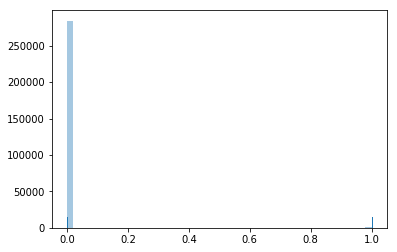

In [3]:
# Take a look at the classes as a bar chart
sns.distplot(df[['Class']], kde=False, rug=True)

In [4]:
# Count number of fraudulent transactions
print('Number of fraudulent transactions: {} or {}%'.format(df.Class.sum(), 
                                                            round(df.Class.sum()/len(df.Class)*100,2)))
print('Total transactions: {}'.format(len(df.Class)))

Number of fraudulent transactions: 492 or 0.17%
Total transactions: 284807


Indeed there is quite an imbalance between the classes. Only 0.17% of the data are fradulent! That's a good sign for the merchant, but certainly presents a challenge in modeling fraud detection. 

Let's run with some exploratory visual analysis of the interactions among features. Assuming that the first two features, V1 and V2 likely encode the most variation in the original dataset (this is very much an assumption), we can start by plotting these features. 

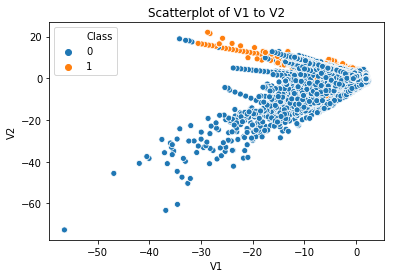

In [5]:
# Scatter plot of first two PCA-generated variables
ax = sns.scatterplot(x="V1", y="V2", hue="Class", data=df)
ax.set_title('Scatterplot of V1 to V2')
plt.show()

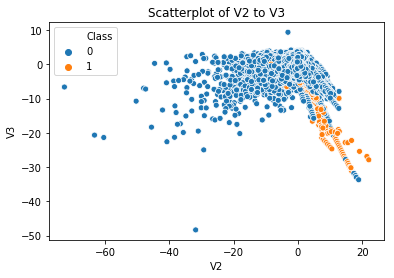

In [6]:
# Scatter plot of second two PCA-generated variables
ax = sns.scatterplot(x="V2", y="V3", hue="Class", data=df)
ax.set_title('Scatterplot of V2 to V3')
plt.show()

There appears to be some separation but also some overlap between the fraudulent and non-fradulent transactions. This is a good sign in that the task of modeling risk is certainly doable, but acheiving a high precision or Area Under the Precision-Recall Curve (AUPRC) will likely be non-trivial. I choose precision and AUPRC as key metrics here because of the extreme class imbalance in the dataset. 

The orthoganol transformation of the initial PCA used to generate the features is quite apparent when comparing the two plots above.

From here, let's take a look at the distributions of the two non-PCA generated features: Time and Transaction Amount

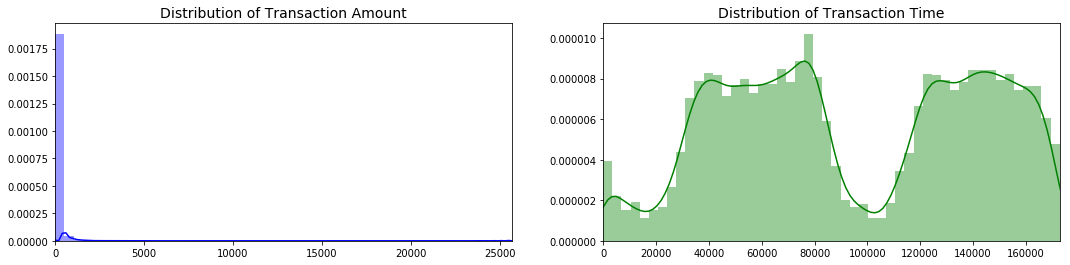

In [7]:
# Plotting distributions of transaction amount and transaction time features
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Values of features for clean Seaborn plotting code
amount_val = df['Amount'].values
time_val = df['Time'].values

# Distribution of transaction amount
sns.distplot(amount_val, ax=ax[0], color='b')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# Distribution of transaction time
sns.distplot(time_val, ax=ax[1], color='g')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

There is clearly a scale issue here - each of the PCA-generated features are already scaled but these two features are not. That means the first step in the modeling process is going to be scaling these features. 

# Methodology
1. First, as discussed previously, the two non-PCA generated features must be scaled appropriately.
2. Next, split the dataset into testing and training sets. It is essential to split the dataset into testing and training sets prior to under or over sampling to ensure that the models we train are evaluated against data from the original dataset and not any synthetic data generated for oversampling or randomly undersampled data.
3. With training and testing subsets defined, create a baseline for future model performance - fit and predict with a simple logistic regression classifier with default parameters.
4. Assess the impact of oversampling the minority, or fradulent, data class by comparing two similar techniques: SMOTE and SVMSMOT resampling. These will be applied in a pipeline using cross validation and a logistic regression classifier with semi-optimal parameters identified using randomized search cross validation. 
5. With an oversampling approach identified as a more robust  technique, train a simple neural network based on that technique to improve model performance over the baseline logistic regression model. 
6. Assess model performance. 

## Scaling non-PCA features
The distributions of transaction amount shows a stark left-skew. That is, the majority of transactions are quite low, but there are a few extremely high transaction amounts. To make sure the scaling process isn't negatively affected by those outliers, we will use the RobustScaler for the transaction amount feature. While the time feature isn't quite so skewed, so a standard scalar should be sufficient. 

In [8]:
# Import scaling functions
# RobustScaler is less prone to influence from outliers, which are present in the amount feature
from sklearn.preprocessing import StandardScaler, RobustScaler

# Inialize scalers
std_scaler = StandardScaler()
rbst_scaler = RobustScaler()

# Fit and transform scalers to create newly scaled features
df['scaled_amount'] = rbst_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop the non-scaled features
df.drop(['Time','Amount'], axis=1, inplace=True)

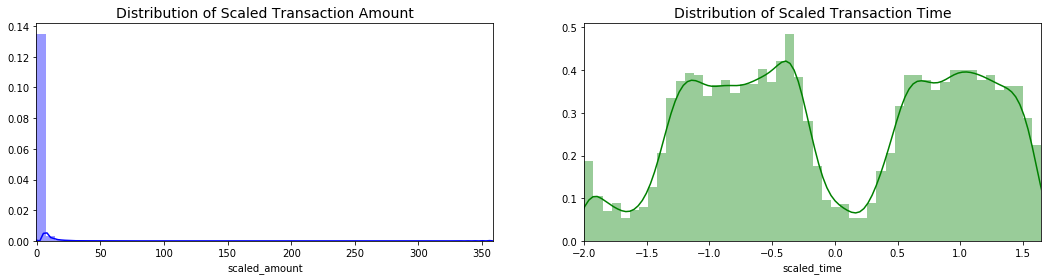

In [9]:
# Plotting distributions of SCALED amount and time features
fig, ax = plt.subplots(1, 2, figsize=(18,4))

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# Distribution of scaled amount
sns.distplot(scaled_amount, ax=ax[0], color='b')
ax[0].set_title('Distribution of Scaled Transaction Amount', fontsize=14)
ax[0].set_xlim([min(scaled_amount), max(scaled_amount)])

# Distribution of scaled time
sns.distplot(scaled_time, ax=ax[1], color='g')
ax[1].set_title('Distribution of Scaled Transaction Time', fontsize=14)
ax[1].set_xlim([min(scaled_time), max(scaled_time)])

plt.show()

## Train-test split using StratifiedKFold
It's necessary to preserve the class imbalance in the training/testing subsets. StratifiedKFold preserves this imbalance inasmuch as possible.

In [10]:
# Import libraries to split the dataset and preserve the class imbalance while doing so
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Assess the class imbalance to ensure accurate comparison
print('Non-fraudulent transactions comprise', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraudulent transactions comprise', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Create the X and y subsets for independent and dependent variables
X = df.drop('Class', axis=1)
y = df['Class']

# Initialize a StratifiedKFold model with 5 splits
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Apply the 5 splits
for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Non-fraudulent transactions comprise 99.83 % of the dataset
Fraudulent transactions comprise 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [11]:
# Let's do a sanity check the distribution of the labels for the train/test subsets

# Turn original testing and training sets into arrays
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Compare the distributions of the training/testing 
# np.unique creates two arrays: one with an array of the levels and
# one with a count of each of the levels
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 50)

# Print out the label distributions
print('Label Distributions: \n')
print('Distribution of the training subset {}'.format(train_counts_label/ len(original_ytrain)))
print('Distribution of the testing subset {}'.format(test_counts_label/ len(original_ytest)))
print('-' * 50)

--------------------------------------------------
Label Distributions: 

Distribution of the training subset [0.99827076 0.00172924]
Distribution of the testing subset [0.99827952 0.00172048]
--------------------------------------------------


# Assess a baseline for model performance
Here, we fit and predict with a simple logistic regression model using default parameters as a baseline for model performance improvements using oversampling and different models/parameters.

In [39]:
# Initiate LogisticRegression model with default params
log_reg = LogisticRegression(C=1e5, solver='liblinear') 

log_reg.fit(original_Xtrain, original_ytrain) # Fit the LogisticRegression model.
y_pred = log_reg.predict(original_Xtest) # Predict y_pred values using X_test features.


accuracy_baseline = float('%.3f' % accuracy_score(original_ytest, y_pred))
ROCAUC_baseline =  float('%.3f' % roc_auc_score(original_ytest, y_pred))
recall_baseline = float('%.3f' % recall_score(original_ytest, y_pred))
f1_baseline = float('%.3f' % f1_score(original_ytest, y_pred))

print('Accuracy:', accuracy_baseline)
print('ROC AUC Score:', ROCAUC_baseline)
print('Recall Score:', recall_baseline)
print('f1 Score:', f1_baseline)

Accuracy: 0.999
ROC AUC Score: 0.74
Recall Score: 0.48


## SMOTE and SVMSMOTE - Oversampling
**SMOTE** stands for Synthetic Minority Oversampling Technique. SMOTE creates new synthetic points in order to have an equal balance of the classes. This is a popular option for solving the problem of class imbalance, which is fundamental to risk modeling applications. 

The synthetic points that SMOTE creates are drawn from the minority class in order to reach an equal balance between the minority and majority class. To do this, SMOTE identifies the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. This 'fills in' any gaps in the minority class clusters to generate synthetic data that replicate the minority class. As a result, SMOTE is generally more robust than traditional undersampling because it retains more information. 

In order to not influence the validation set, SMOTE is applied _during_ the cross validation pipeline. In this way, synthetic data are created only for the training set without affecting the validation set. After all, it would not be a good idea to validate a model on synthetic data. 

I'll apply both SMOTE and a newer variant of SMOTE - **SVMSMOTE** which uses a support vector machine classifier to find support vectors and generate samples considering them. 

In [40]:
# Sanity check on training and testing set sizes before applying a pipeline

print('-' * 60)
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), 
                                                                 len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), 
                                                               len(original_ytest)))
print('-' * 60)

------------------------------------------------------------
Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
------------------------------------------------------------


In [14]:
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# List to append the score and then find the average
smote_accuracy_lst = []
smote_precision_lst = []
smote_recall_lst = []
smote_f1_lst = []
smote_auc_lst = []

# Instantiate logistic regression classifier
log_reg_sm = LogisticRegression()

# Parameters to test
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

# Run randomized search cross validation 
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

In [16]:
# Implementing SMOTE Technique 
for train, test in skf.split(original_Xtrain, original_ytrain):
    # Incorporate SMOTE oversampling during cross validation 
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) 
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    smote_best_est = rand_log_reg.best_estimator_
    prediction = smote_best_est.predict(original_Xtrain[test])
    
    smote_accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    smote_precision_lst.append(precision_score(original_ytrain[test], prediction))
    smote_recall_lst.append(recall_score(original_ytrain[test], prediction))
    smote_f1_lst.append(f1_score(original_ytrain[test], prediction))
    smote_auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('-' * 60)
print("accuracy: {}".format(np.mean(smote_accuracy_lst)))
print("precision: {}".format(np.mean(smote_precision_lst)))
print("recall: {}".format(np.mean(smote_recall_lst)))
print("f1: {}".format(np.mean(smote_f1_lst)))
print('-' * 60)

------------------------------------------------------------

accuracy: 0.9422950412362467
precision: 0.06049517062444994
recall: 0.9111002921129504
f1: 0.111747549212697
------------------------------------------------------------


In [21]:
labels = ['No Fraud', 'Fraud']
smote_prediction = smote_best_est.predict(original_Xtest)
print('Classification report for SMOTE applied in a logistic regression pipeline:')
print(classification_report(original_ytest, smote_prediction, target_names=labels))

Classification report for SMOTE applied in a logistic regression pipeline:
              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.19        98

   micro avg       0.99      0.99      0.99     56961
   macro avg       0.55      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



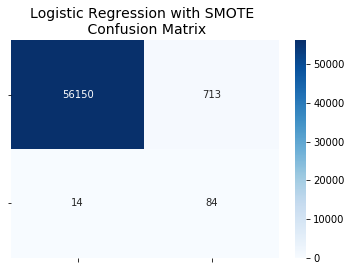

In [41]:
from sklearn.metrics import confusion_matrix

log_reg_cf = confusion_matrix(original_ytest, smote_prediction)

ax = sns.heatmap(log_reg_cf, annot=True,cmap='Blues', fmt='g')
ax.set_title("Logistic Regression with SMOTE \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)
plt.show()

The good news is that this model catches most of the fraudulent transactions. But the much more important bad news is that there are quite a significant number of false negatives - these will be many unhappy customers. As a result, the model needs to do better. But first, let's check the precision-recall for logistice regression applied in a SMOTE pipeline. 

In [47]:
# Check the average precision-recall for the best estimator
smote_y_score = smote_best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, smote_y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.74


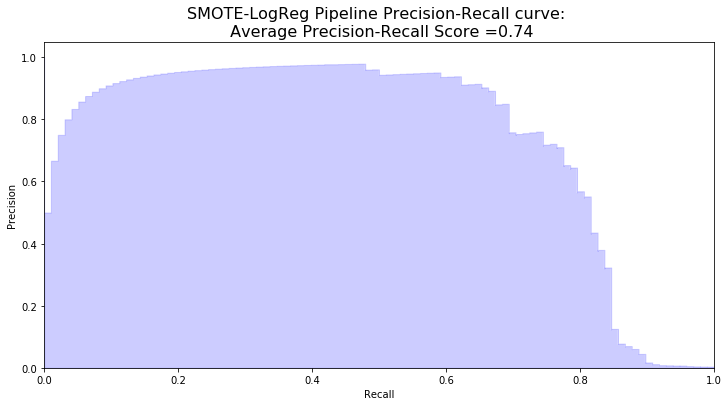

In [34]:
# Plot the Precision-Recall curve from the SMOTE logistic regression pipeline
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='w', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('SMOTE-LogReg Pipeline Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)
plt.show()

## Trying out SVMSMOTE
SVMSMOTE is a much newer technique for synthetically producing additional samples, in this case from the minority fraud class. I apply it here to compare to the regular SMOTE technique to see if there are any performance gains using the same parameters and the same Logistic Regression classifier as trained using SMOTE as part of the cross validation pipeline.

In [35]:
# List to append the score and then find the average
svmsmote_accuracy_lst = []
svmsmote_precision_lst = []
svmsmote_recall_lst = []
svmsmote_f1_lst = []
svmsmote_auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

# RandomizedSearchCrossValidation with logistic regression parameters
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

In [42]:
# Implementing SVMSMOTE Technique 
# Cross Validation pipeline
for train, test in skf.split(original_Xtrain, original_ytrain):
    # Implement SVMSMOTE in the pipeline
    pipeline = imbalanced_make_pipeline(SVMSMOTE(sampling_strategy='minority'), rand_log_reg) 
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    svmsmote_best_est = rand_log_reg.best_estimator_
    svmsmote_prediction = svmsmote_best_est.predict(original_Xtrain[test])
    
    svmsmote_accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    svmsmote_precision_lst.append(precision_score(original_ytrain[test], svmsmote_prediction))
    svmsmote_recall_lst.append(recall_score(original_ytrain[test], svmsmote_prediction))
    svmsmote_f1_lst.append(f1_score(original_ytrain[test], svmsmote_prediction))
    svmsmote_auc_lst.append(roc_auc_score(original_ytrain[test], svmsmote_prediction))
    
print('-' * 60)
print("accuracy: {}".format(np.mean(svmsmote_accuracy_lst)))
print("precision: {}".format(np.mean(svmsmote_precision_lst)))
print("recall: {}".format(np.mean(svmsmote_recall_lst)))
print("f1: {}".format(np.mean(svmsmote_f1_lst)))
print('-' * 60)

------------------------------------------------------------

accuracy: 0.9815996710959523
precision: 0.2019224701669927
recall: 0.8755274261603375
f1: 0.30458324144656485
------------------------------------------------------------


In [44]:
labels = ['No Fraud', 'Fraud']  
svmsmote_prediction = svmsmote_best_est.predict(original_Xtest)
print('Classification report for SVMSMOTE applied in a Logistic Regression Pipeline:')
print(classification_report(original_ytest, svmsmote_prediction, target_names=labels))

Classification report for SVMSMOTE applied in a Logistic Regression Pipeline:
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56863
       Fraud       0.51      0.80      0.62        98

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.76      0.90      0.81     56961
weighted avg       1.00      1.00      1.00     56961



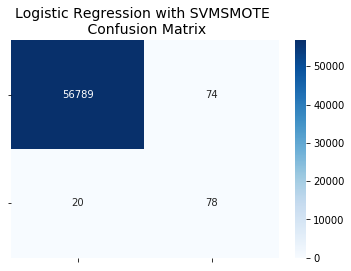

In [45]:
from sklearn.metrics import confusion_matrix

log_reg_cf = confusion_matrix(original_ytest, svmsmote_prediction)

ax = sns.heatmap(log_reg_cf, annot=True, cmap='Blues', fmt='g')
ax.set_title("Logistic Regression with SVMSMOTE \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)
plt.show()

This represents a significant improvement in reducing the number of false negatives over the standard SMOTE technique. However, this comes at the expense of a decrease in the number of true negatives compared to SMOTE. Overall from a business standpoint, using SVMSMOTE would likely be more optimal because it negatively impacts 10 times fewer customers who are not fraudsters. 

In [54]:
# Check the average precision-recall for the best estimator using SVMSMOTE
svmsmote_y_score = svmsmote_best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, svmsmote_y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.74


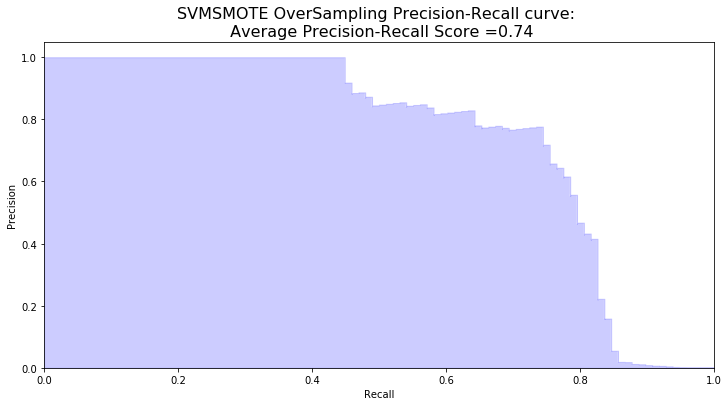

In [55]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='w', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('SVMSMOTE OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)
plt.show()

With predictions from both SMOTE and SVMSMOTE, it's worthwhile to compare both approaches to handling the class imbalance. I'll use the f1 score, or the harmonic mean of precision and recall, to assess performance. 

In [58]:
# Logistic Regression with SMOTE oversampling
y_pred_smote = smote_best_est.predict(original_Xtest)
smote_score = f1_score(original_ytest, y_pred_smote)

# Logistic Regression with SVMSMOTE oversampling
y_pred_svmsmote = svmsmote_best_est.predict(original_Xtest)
svmsmote_score = f1_score(original_ytest, y_pred_svmsmote)


d = {'Technique': ['SMOTE Oversampling', 'SVMSMOTE Oversampling'], 'Score': [smote_score, svmsmote_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Print accuracy
final_df

,Technique,Score
0,SMOTE Oversampling,0.187709
1,SVMSMOTE Oversampling,0.624000


SVMSMOTE provides a significantly increased f1 score relative to using SMOTE. As a result, we will retain the SVMSMOTE technique in the data pipeline and apply it alongside other models. SVMSMOTE clearly comes with the advantage of leading to better performance over baseline (no over/under sampling) and over traditional SMOTE, but it does come at a few costs. First are of course the lower number of false positives, meaning that more fraudsters are _not_ getting caught. We can tackle this with a more generalizable model such as a deep learning model, however. On the other hand, SVMSMOTE is a bit more resource intensive to apply. This isn't necessarily the worst trade-off but it depends on how the model will be trained in production. If it's a batch process run overnight, then the additional resource requirements shouldn't be too much of a negative, but if the model operates on streaming data, this could lead to heavy delays in processing time that would discount such an approach. Most likely it's the former.

In [62]:
# SVMSMOTE Technique (OverSampling) After splitting and Cross Validating
svmsm = SVMSMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to use for model training
Xsvmsm_train, ysvmsm_train = svmsm.fit_sample(original_Xtrain, original_ytrain)

In [65]:
# Setup a really simple deep learning model
n_inputs = Xsvmsm_train.shape[1]

svmsmote_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [67]:
svmsmote_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Compile the neural network with 
# an Adam loss rate of 0.001 and 
# sparse categorical crossentropy for the class imbalance
svmsmote_model.compile(Adam(lr=0.001), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

In [69]:
# Fit the basic neural network to the SVMSMOTE training data
svmsmote_model.fit(Xsvmsm_train, ysvmsm_train, 
                   validation_split=0.2, 
                   batch_size=25, 
                   epochs=20, 
                   shuffle=True, 
                   verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 53s - loss: 0.0105 - acc: 0.9974 - val_loss: 0.0097 - val_acc: 0.9969
Epoch 2/20
 - 50s - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0044 - val_acc: 0.9998
Epoch 3/20
 - 50s - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 4/20
 - 50s - loss: 0.0033 - acc: 0.9995 - val_loss: 2.8204e-04 - val_acc: 0.9999
Epoch 5/20
 - 49s - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0059 - val_acc: 0.9988
Epoch 6/20
 - 50s - loss: 0.0028 - acc: 0.9996 - val_loss: 9.1414e-04 - val_acc: 0.9998
Epoch 7/20
 - 50s - loss: 0.0027 - acc: 0.9996 - val_loss: 9.6789e-04 - val_acc: 0.9998
Epoch 8/20
 - 50s - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 9/20
 - 50s - loss: 0.0025 - acc: 0.9997 - val_loss: 2.2816e-04 - val_acc: 1.0000
Epoch 10/20
 - 50s - loss: 0.0023 - acc: 0.9997 - val_loss: 6.2885e-04 - val_acc: 1.0000
Epoch 11/20
 - 50s - loss: 0.0022 - acc:

In [70]:
# Generate predictions from the SVMSMOTE model
# on the original test dataset
svmsmote_model_predictions = svmsmote_model.predict(original_Xtest, 
                                                    batch_size=200, 
                                                    verbose=0)

In [71]:
# Generate fraud predictions from the SVMSMOTE model
# on the original test dataset
svmsmote_fraud_predictions = svmsmote_model.predict_classes(original_Xtest, 
                                                              batch_size=200, 
                                                              verbose=0)

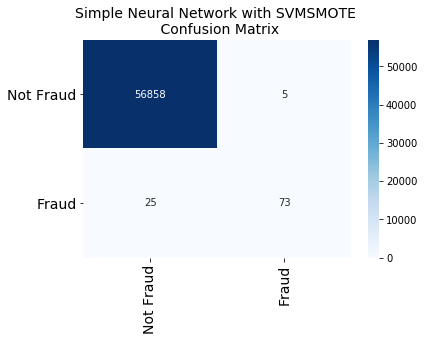

In [85]:
# Assess performance with a confusion matrix
svmsmote_cm = confusion_matrix(original_ytest, svmsmote_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['Not Fraud', 'Fraud']


ax = sns.heatmap(svmsmote_cm, annot=True, cmap='Blues', fmt='g')
ax.set_title("Simple Neural Network with SVMSMOTE \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(labels, fontsize=14, rotation=90)
ax.set_yticklabels(labels, fontsize=14, rotation=360)

plt.show()

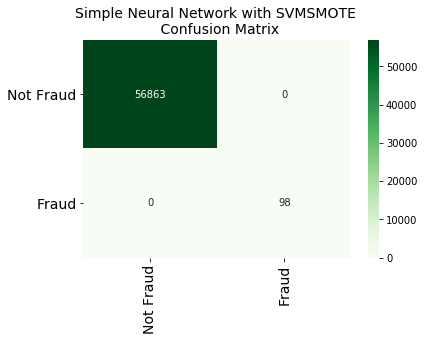

In [88]:
# Compare to confusion matrix of test data
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['Not Fraud', 'Fraud']

ax = sns.heatmap(actual_cm, annot=True, cmap='Greens', fmt='g')
ax.set_title("Simple Neural Network with SVMSMOTE \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(labels, fontsize=14, rotation=90)
ax.set_yticklabels(labels, fontsize=14, rotation=360)

plt.show()

This is a fairly decent result - only 5 out of 56863 transactions are mislabelled as fraud. Unfornately, however, some 25 out of 98 fraudsters got away with their fraud. But at least over 75% of fraudsters were caught! And this is with a really basic neural network. 

I hope you enjoyed this fraud detection data challenge run through. 